# Waveform Analysis Exploration 

Need a function for mass data addition (all the unique EDF files). I'll merge them into a single table for easy analysis. Waves are waves-- so long as they have the same filtering and they're all originally raw EEG! 

Since there's a major problem with unreliable annotations, I'm taking matters into my own hands and manually constructing a label list for fixed 30s intervals. I'll do this by binning annotations from the paired Hypnogram for each file. 
- Going to time-align the labels using `raw.annotations` 
- Then slice the entire sleep period into 30s chunks 
- Finally, assign the sleep stage based on the label-list 

In [2]:
import numpy as np
import pandas as pd
import mne 
from mne.time_frequency import psd_array_welch
import matplotlib.pyplot as plt

def process_edf_pair(psg_path, hypnogram_path): 
    '''
    Loads EDF EEG recording and corresponding hypnogram 
    Extracts 30s epochs, labels them, and returns a features df

    Returns: 
        features (pd.DataFrame): Features + newly created 'label' col (sleep stage as str)
    '''

    raw = mne.io.read_raw_edf(psg_path, preload=True) 
    raw.set_annotations(mne.read_annotations(hypnogram_path))
    raw.pick(['EEG Fpz-Cz']) 

    data = raw.get_data()[0]
    sfreq = raw.info['sfreq']
    total_duration = int(data.shape[-1] / sfreq) # in seconds!

    # Map annotation label -> clean stage name
    stage_map = {
        'Sleep stage W': 'Wake',
        'Sleep stage 1': 'N1',
        'Sleep stage 2': 'N2',
        'Sleep stage 3': 'N3',
        'Sleep stage 4': 'N3', # Mergnig 4 into N3
        'Sleep stage R': 'REM'
    }

    epoch_length = 30 # seconds
    n_epochs = total_duration // epoch_length
    labels = ['UNKNOWN'] * n_epochs

    for ann in raw.annotations:
        label = stage_map.get(ann['description'], None)
        if label is None: 
            continue
        start = int(ann['onset']) // epoch_length
        duration = int(ann['duration']) // epoch_length

        for i in range(start, min(start + duration, n_epochs)):
            labels[i] = label

    # Remove unknown-labeled epochs
    valid_idxs = [i for i, l in enumerate(labels) if l != 'UNKNOWN'] 

    # Manually epoch the signal into 30s chunks 
    samples_per_epoch = int(epoch_length * sfreq) 
    epoch_data = np.array([
        data[i * samples_per_epoch:(i+1) * samples_per_epoch]
        for i in valid_idxs if (i+1) * samples_per_epoch <= len(data) 
    ])
        
    # Compute bandpower features 
    psds, freqs = psd_array_welch(epoch_data[:, np.newaxis, :], sfreq=sfreq, fmin=0.5, fmax=40, n_fft=256)

    features = pd.DataFrame({
        'delta': bandpower(psds, freqs, (0.5, 4)),
        'theta': bandpower(psds, freqs, (4, 8)),
        'alpha': bandpower(psds, freqs, (8, 13)),
        'beta':  bandpower(psds, freqs, (13, 30)),
        'label': [labels[i] for i in valid_idxs]
    })

    # Adding subject ID derived from filename (ex. "ST7011J") 
    subj_id = psg_path.name[2:6]
    features['subject_id'] = subj_id

    return features

def bandpower(psds, freqs, band):
    '''
    Small hepler for process_edf_pair
    Returns mean band power in specified frequency band
    '''
    idx = (freqs >= band[0]) & (freqs <= band[1])
    return psds[:, :, idx].mean(axis=-1).mean(axis=1)



### Now Loop over all .edf files!

In [ ]:
import os
from src.paths import DATA_DIR

# Match PSG and Hypnogram files by prefix

data_dir = DATA_DIR / 'sleep_waves'
files = os.listdir(data_dir) 

# Grouping PSG and Hypnogram files by shared sybject root (first 7 chars) 
psg_files = [f for f in files if f.endswith('-PSG.edf')]
hyp_files = [f for f in files if 'Hypnogram' in f] 

file_pairs = []

for psg in psg_files:
    subj_root = psg[:7] # example: 'ST7011J'
    matching_hyp = [h for h in hyp_files if h.startswith(subj_root)]

    if matching_hyp: 
        psg_path = data_dir / psg
        hyp_path = data_dir / matching_hyp[0] # Note: assuming only 1 match! 
        file_pairs.append((psg_path, hyp_path)) 
    else: 
        print(f'No matching hypnogram for {psg}')

print(f'Found {len(file_pairs)} valid PSG-Hypnogram edf pairs') 

# Process all and concat 
all_feats = []

for psg, hyp in file_pairs:
    print(f"🧪 Processing: {os.path.basename(psg)} & {os.path.basename(hyp)}")
    try: 
        features = process_edf_pair(psg, hyp)
        all_feats.append(features) 
        print(f'\n✅ Processed: {os.path.basename(psg)}:{len(features)} epochs\n')
    except Exception as e: 
        print(f'❌ Failed on {psg}: {e}')

df_edf = pd.concat(all_feats, ignore_index=True) 




# Feature Engineering

### Why Distinguish Between Subjects? 
Sleep progresses through ~4-5 distinct cycles per night (each 90-100 mins). Each cycle starts in N1 / Wake (still digging for this answer), and progresses to REM. We've learned that later cycles (in a typical night sleep) have less N3 and more REM.  
  
  Since these patterns are subject-specific, it makes sense to segmenet by subject and learn from these cycles within a given night. If we know where cycles start and end, the HMM can follow real transitions, preventing overfitting.

### Adding new column `cycle` before model training:

### Cycle Detection v2.0
The previous system was an excellent step forward. However, an average cycle number of ~1.94 is *much* lower than what modern reserach agrees upon (4-6 cycles / night). It's understandable that some subjects might have tumultuous sleeps, but that average cycle count has to get closer to the national average!

*New and Improved!*
1. Waits for the first NREM to start 'real' sleep
2. Tracks REM streaks-- when a long enough one ends, checks if a full cycle can end (meets min/max epoch reqs)
3. If valid, assigns a cycle number to that segment
4. Continues through the sequence; ignores noise and edge cases!   
  
**Note**: Pre-sleep (Wake, N1) to cycle = 0  
**Note**: caps total sleep cycles to 7

In [14]:
def segment_sleep_cycles(
    stages,
    min_cycle_duration=120,
    max_cycle_duration=400,
    min_rem_streak=8,
    max_cycles=7):
    '''
    Segments sleep data into cycles only when REM ends and NREM begins again 

    Parameters: 
        stages (list): list of sleep stages
        min_cycle_duration (int): min cycle duration 
        max_cycle_duration (int): max cycle duration 
        min_rem_streak (int): min number of REM epochs to be valid 
        max_cycles (int) max cycles possible 
    
    Returns: 
        cycle_labels (list): list of cycle labels for each epoch
    '''
    n = len(stages)
    cycle_labels = [0] * n  # Start with all epochs labeled Cycle 0 (presleep)
    cycle_id = 1
    in_sleep = False
    sleep_started = False
    current_start = None
    in_rem = False
    rem_start = None
    post_rem_waiting = False
    last_valid_cycle = 0

    for i in range(n):
        stage = stages[i]

        # Wait for first NREM to initiate sleep
        if not in_sleep:
            if stage in ['N2', 'N3']:
                in_sleep = True
                sleep_started = True
                current_start = i
            continue

        # Begin REM streak
        if stage == 'REM':
            if not in_rem:
                rem_start = i
                in_rem = True
            # Still assign the last valid cycle
            if last_valid_cycle > 0:
                cycle_labels[i] = last_valid_cycle
            continue

        # End REM streak
        if in_rem and stage != 'REM':
            rem_length = i - rem_start
            in_rem = False
            if rem_length >= min_rem_streak:
                post_rem_waiting = True

        # After valid REM, wait for NREM to close and start next cycle
        if post_rem_waiting and stage in ['N2', 'N3']:
            cycle_len = i - current_start
            if min_cycle_duration <= cycle_len <= max_cycle_duration:
                for j in range(current_start, i):
                    cycle_labels[j] = cycle_id
                last_valid_cycle = cycle_id
                cycle_id += 1
                current_start = i
                post_rem_waiting = False

                if cycle_id > max_cycles:
                    break
            else:
                post_rem_waiting = False

        # Assign ongoing epochs with current or last cycle
        if sleep_started:
            if current_start is not None and cycle_id > 1:
                cycle_labels[i] = cycle_id - 1
            elif last_valid_cycle > 0:
                cycle_labels[i] = last_valid_cycle

    # Label final NREM if it meets duration
    if current_start is not None and (n - current_start) >= min_cycle_duration:
        for j in range(current_start, n):
            cycle_labels[j] = cycle_id
        last_valid_cycle = cycle_id

    # Final sweep: fill in any remaining 0s after sleep started
    if sleep_started:
        for i in range(current_start, n):  # Only fill from sleep onset forward
            if cycle_labels[i] == 0:
                cycle_labels[i] = last_valid_cycle

    return cycle_labels


def apply_cycle_detection(df:pd.DataFrame): 
    '''
    Applies cycle detection to each subject, and assigns a 'cycle' col

    Params: 
        df: DataFrame that contains 'subject_id' and 'label' cols
    
    Retuns: 
        df: Same df with new 'cycle' col
    '''
    df = df.copy() 
    df['cycle'] = None # Pre-allocation! 

    for subject, group in df.groupby('subject_id'):
        stages = group['label'].tolist()
        cycles = segment_sleep_cycles(stages)
        df.loc[group.index, 'cycle'] = cycles 

    df['cycle'] = df['cycle'].astype(int) 
    df['subject_id'] = df['subject_id'].astype(int)
    return df

In [17]:
df_edf = apply_cycle_detection(df_edf)
# df_edf.groupby('subject_id')['cycle'].value_counts(normalize=True)
df_edf['cycle'].value_counts(normalize=True)

cycle
1    0.321637
2    0.226957
3    0.213980
4    0.128247
5    0.063526
0    0.045654
Name: proportion, dtype: float64

## Creating Binary Labels (REM/NREM)

In [22]:
def create_binary_label(stage_label): 
    '''
    Convert full sleep stage labels to binary REM/NREM 
    '''
    return 'REM' if stage_label == 'REM' else 'NREM'

df_edf['binary_label'] = df_edf['label'].apply(create_binary_label)

In [ ]:
# from sleep_wave.features.builders import feat_time_context


# df_edf = feat_time_context(df_edf)
# df_edf


,delta,theta,alpha,beta,label,subject_id,cycle,binary_label,time_index,norm_time
0,6.160646e-12,3.309411e-12,1.943593e-12,2.366059e-12,Wake,7011,0,NREM,0,0.000000
1,4.988774e-10,1.235113e-11,4.446865e-12,2.844799e-12,Wake,7011,0,NREM,1,0.000917
2,1.534984e-10,2.390680e-12,1.519197e-12,5.406593e-13,Wake,7011,0,NREM,2,0.001833
3,4.962507e-11,2.943184e-12,1.687577e-12,5.375286e-13,Wake,7011,0,NREM,3,0.002750
4,2.378089e-11,1.779550e-12,2.156748e-12,4.648331e-13,Wake,7011,0,NREM,4,0.003666
...,...,...,...,...,...,...,...,...,...,...
42686,4.120337e-11,7.154511e-12,1.723270e-12,2.457063e-13,N2,7242,4,NREM,934,0.995736
42687,9.937038e-11,4.455668e-12,1.793157e-12,3.096157e-13,N2,7242,4,NREM,935,0.996802
42688,2.846232e-10,1.342760e-11,3.760796e-12,3.510913e-12,Wake,7242,4,NREM,936,0.997868
42689,9.707442e-10,2.485227e-11,6.117589e-12,8.264715e-12,Wake,7242,4,NREM,937,0.998934


In [1]:
df_edf = df_edf.loc[:, ~df_edf.columns.duplicated()]
df_edf.to_csv('../data/eeg_hypno.csv', index=False)

df_edf

NameError: name 'df_edf' is not defined

<hr>

# Quickload through the .csv
Skip to here to avoid generating files for the thousanth time

In [ ]:
import sys 
import os

from src.utils.loaders import load_eeg_data

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(PROJECT_ROOT)

import pandas as pd
import matplotlib.pyplot as plt
from src.paths import DATA_DIR

# df_edf = pd.read_csv('../data/eeg_hypno.csv')
# df_edf = pd.read_csv(DATA_DIR / 'eeg_hypno.csv')
df_edf = load_eeg_data('eeg_hypno.csv')

df_edf

[INFO] Loading from local: c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\eeg_hypno.csv


,delta,theta,alpha,beta,label,subject_id,cycle,binary_label,time_index,norm_time
0,6.160646e-12,3.309411e-12,1.943593e-12,2.366059e-12,Wake,7011,0,NREM,0,0.000000
1,4.988774e-10,1.235113e-11,4.446865e-12,2.844799e-12,Wake,7011,0,NREM,1,0.000917
2,1.534984e-10,2.390680e-12,1.519197e-12,5.406593e-13,Wake,7011,0,NREM,2,0.001833
3,4.962507e-11,2.943184e-12,1.687577e-12,5.375286e-13,Wake,7011,0,NREM,3,0.002750
4,2.378089e-11,1.779550e-12,2.156748e-12,4.648331e-13,Wake,7011,0,NREM,4,0.003666
...,...,...,...,...,...,...,...,...,...,...
42686,4.120337e-11,7.154511e-12,1.723270e-12,2.457063e-13,N2,7242,4,NREM,934,0.995736
42687,9.937038e-11,4.455668e-12,1.793157e-12,3.096157e-13,N2,7242,4,NREM,935,0.996802
42688,2.846232e-10,1.342760e-11,3.760796e-12,3.510913e-12,Wake,7242,4,NREM,936,0.997868
42689,9.707442e-10,2.485227e-11,6.117589e-12,8.264715e-12,Wake,7242,4,NREM,937,0.998934


: 

In [7]:
df_edf['binary_label'].value_counts(normalize=True) 

binary_label
NREM    0.804432
REM     0.195568
Name: proportion, dtype: float64

### Training a Basic Classifier (RF)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

X = df_edf.drop(columns=['binary_label', 'label', 'subject_id'])
y = df_edf['binary_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=10)

base_rf = RandomForestClassifier(n_estimators=100, random_state=10, class_weight='balanced')
base_rf.fit(X_train, y_train) 

y_pred = base_rf.predict(X_test) 
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        NREM       0.90      0.95      0.92      6869
         REM       0.74      0.56      0.63      1670

    accuracy                           0.87      8539
   macro avg       0.82      0.75      0.78      8539
weighted avg       0.87      0.87      0.87      8539



### Pipeline Project Adapted to Waveforms (LONG WAIT, HYPERPARAM TUNING):

In [5]:
import sys
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

import sys 
import os
sys.path.append(os.path.abspath(".."))

from src.run_pipeline import tune_and_train_full

# Label Encoding with decoding built into tune_and_train_full()
le = LabelEncoder()
y_encoded = le.fit_transform(y) 

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, stratify=y_encoded, random_state=10)

lgbm_wave, best_params, final_metrics = tune_and_train_full(
    model_class=LGBMClassifier,
    model_name='LGBM_wave',
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_params={'class_weight': 'balanced'},
    sample_frac=0.9,
    scoring='f1_weighted',
    use_scaler=False,
    n_trials=1,
    label_encoder=le  
)

🔍 Sampled 28816 rows (90.0%)
Class distribution:
1    13399
3     5636
2     4330
4     2985
0     2466



🔍 Tuning: 100%|██████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.40s/it]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 28816, number of used features: 6
[LightGBM] [Info] Start training from score -2.458333
[LightGBM] [Info] Start training from score -0.765751
[LightGBM] [Info] Start training from score -1.895363
[LightGBM] [Info] Start training from score -1.631756
[LightGBM] [Info] Start training from score -2.267331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [3]:
sys.path.append(os.path.abspath(".."))

import joblib
from sklearn.preprocessing import LabelEncoder
from src.eval import eval_classification 

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # y is label column
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=10)

lgbm_pipeline = joblib.load('../models/LGBM_wave.pkl')

eval_classification(lgbm_pipeline, X_test, y_test, label_encoder=le) 



Label decoder active:
  y_test unique: [0 1 2 3 4]
  Classes: ['N1' 'N2' 'N3' 'REM' 'Wake']

Evaluating Model: LGBMClassifier
Hyperparameters:
{
    "boosting_type": "gbdt",
    "class_weight": "balanced",
    "colsample_bytree": 1.0,
    "importance_type": "split",
    "learning_rate": 0.05209032565537784,
    "max_depth": 32,
    "min_child_samples": 20,
    "min_child_weight": 0.001,
    "min_split_gain": 0.0,
    "n_estimators": 200,
    "n_jobs": null,
    "num_leaves": 122,
    "objective": null,
    "random_state": null,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0,
    "subsample": 1.0,
    "subsample_for_bin": 200000,
    "subsample_freq": 0
}

Overall Metrics:
| Metric             |   Score |
|:-------------------|--------:|
| Accuracy           |  0.7953 |
| Weighted Precision |  0.8021 |
| Weighted Recall    |  0.7953 |
| Weighted F1-Score  |  0.7976 |

Class-Specific Metrics:
| Class   |   Precision |   Recall |   F1-Score |   Support |
|:--------|------------:|---------:|

## Great, Classifier is Built! What Now?
Just completed work on a sleep stage classifier that is ~80% effective. While that's not bad... we can do better, by using the elements of the data to our advantage: 
- Sleep is **not** random, it follows structured stage transitions
- HMM can capture those structured transitions as probabilities
- We can use a HMM approach to smooth the pipeline model's predictions into a more biologically probably sequence.


### While Discussing Goals: 
**Real-time sleep classification**. It's possible (with a ton of work). That is our final product. 

<hr>

### Back to Reality: HMM Smoothing Pass 

It's important to remember that the HMM is *not* making new predictions or replacing the already nicely trained and optimized classifier. The HMM will function to refine the outputs.  
  
We'll learn from the data in order to estimate stage transition probabilities. For example: how likely are you to stay in N2, or jump to N3, etc. 

In [58]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import numpy as np

def apply_hybrid_hmm(df: pd.DataFrame, base_predictions, label_encoder, transition_matrices): 
    '''
    Applies hybrid GaussianHMM smoothing to predicted labels using per-cycle transition matrices

    Args: 
        df (pd.DataFrame): EEG data with 'cycle' and 'subject_id' cols
        base_predictions (np.ndarray): Raw model predictions (same order as df) 
        label_encoder (LabelEncoder): Fitted encoder to convert betweeen stages labels and indices
        transition_matrices (dict): 
            Keys= 'early', 'mid', 'late'
            Values= 2D np.ndarray (5x5 transitions)

    Returns: 
        np.ndarray: smoothed predictions using cycle-aware HMM pass-over 
    '''

    df = df.copy()
    df['pred'] = base_predictions

    stage_order = label_encoder.classes_
    n_states = len(stage_order) 

    smoothed_all = []
    used_indices = [] 

    for (subject_id, cycle), group in df.groupby(['subject_id', 'cycle']): 
        if len(group) < n_states:
            print(f"⏭️ Skipping subject {subject_id}, cycle {cycle} — only {len(group)} rows")
            continue

        X = group[['delta', 'theta', 'alpha', 'beta']].values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X) 

        hmm_model = GaussianHMM(n_components=n_states, 
                        covariance_type='full', 
                        n_iter=100, 
                        random_state=10)
        
        # startprob = np.full(n_states, 0.01)
        # wake_index = label_encoder.transform(['Wake'])[0]
        # startprob[wake_index] = 0.95
        # hmm_model.startprob_ = startprob / startprob.sum()
        
        hmm_model.fit(X_scaled) 

        row_sums = hmm_model.transmat_.sum(axis=1)
        if not np.allclose(row_sums, 1):
            print(f"⚠️ Fixing transmat_ for subject {subject_id}, cycle {cycle}")
            transmat = hmm_model.transmat_
            transmat[row_sums == 0] = np.full(n_states, 1.0 / n_states)
            transmat /= transmat.sum(axis=1, keepdims=True)
            hmm_model.transmat_ = transmat

        # # Select transition matrix based on cycle phase
        # if cycle <= 1: 
        #     phase = 'early'
        # elif cycle <= 3:
        #     phase = 'mid'
        # else: 
        #     phase = 'late'

        # transmat = transition_matrices[phase]

        
        # hmm_model.transmat_ = transmat
        
        # Step 3: Override learned transition with hybrid transition logic 
        # hmm_model.transmat_ = transmat.copy()


        # Step 4: Predict (Viterbi) and Decode!
        smoothed_idx = hmm_model.predict(X_scaled)
        smoothed_labels = label_encoder.inverse_transform(smoothed_idx) 

        smoothed_all.extend(smoothed_labels) 
        used_indices.extend(group.index.tolist())

    return np.array(smoothed_all), np.array(used_indices)
    

In [59]:

# Order: ['N1', 'N2', 'N3', 'REM', 'Wake']
transition_matrices = {
    "early": np.array([
        [0.10, 0.85, 0.00, 0.00, 0.05],  # N1 → mostly N2
        [0.00, 0.80, 0.15, 0.00, 0.05],  # N2 → N3
        [0.00, 0.30, 0.65, 0.00, 0.05],  # N3 → N2
        [0.00, 0.00, 0.00, 0.90, 0.10],  # REM → Wake
        [0.40, 0.50, 0.00, 0.00, 0.10],  # Wake → N1/N2
    ]),

    "mid": np.array([
        [0.10, 0.85, 0.00, 0.00, 0.05],
        [0.05, 0.75, 0.10, 0.05, 0.05],
        [0.05, 0.30, 0.60, 0.00, 0.05],
        [0.00, 0.10, 0.00, 0.80, 0.10],
        [0.30, 0.60, 0.00, 0.00, 0.10],
    ]),

    "late": np.array([
        [0.10, 0.80, 0.00, 0.05, 0.05],
        [0.10, 0.65, 0.00, 0.15, 0.10],
        [0.10, 0.20, 0.50, 0.00, 0.20],
        [0.05, 0.15, 0.00, 0.75, 0.05],
        [0.20, 0.65, 0.00, 0.10, 0.05],
    ])
}

In [ ]:
# base_predictions = le.inverse_transform(rf_pipeline.predict(X))
base_preds = rf_pipeline.predict(X) 

smoothed_preds, used_indices = apply_hybrid_hmm(df_edf, base_preds, le, transition_matrices)

### Ready to Visualize the Hybrid HMM's performance

In [ ]:
from src.eval import eval_predictions

eval_predictions(smoothed_preds, np.array(y)[used_indices], le)


In [ ]:
from src.eval import eval_predictions

eval_predictions(lgbm_pipeline.predict(X_test), y_test, le)

In [3]:
from matplotlib.colors import ListedColormap

def plot_subject_sequence(subject_id, model, model_name, df: pd.DataFrame, 
                          label_encoder, label_order=None, n_epochs=50, save_path=None):
    '''
    Visualizes sleep stage preds vs ground truth for a specific subject

    Args: 
        subject_id (int): subject ID to filter rows
        model: Trained classifier with .predict() 
        model_name (str): Name of the model for the plot title
        df (pd.DataFrame): full dataset with 'label' and 'subject_id'
        label_encoder: Fitted label encoder (decoding preds)
        label_order (list): Optional fixed order of labels 
        n_epochs (int): Number of epochs to plot (default=50)
    '''
    # Filter for the subject: 
    df_subj = df[df['subject_id'] == subject_id].copy()

    # Predict: 
    X_subj = df_subj.drop(columns=['label'])
    y_true = df_subj['label'].values

    y_pred = label_encoder.inverse_transform(model.predict(X_subj))

    # For safety, clip to n_epochs available
    n_epochs = min(n_epochs, len(df_subj))
    y_true, y_pred = y_true[:n_epochs], y_pred[:n_epochs] 
    df_subj = df_subj.iloc[:n_epochs]
    
    # Label Mapping
    if label_order is None: 
        label_order = sorted(list(set(y_true) | set(y_pred)))

    label_to_int = {label: i for i, label in enumerate(label_order)} 
    y_true_idx = [label_to_int[y] for y in y_true]
    y_pred_idx = [label_to_int[y] for y in y_pred]

    # Add a thin white row separator between Ground Truth and Classifier
    data = np.array([y_true_idx, y_pred_idx])

    stage_colors = {
        "Wake": "#9b59b6",  # Soft lavender
        "N1": "#f1c40f",     # Yellow
        "REM": "#e67e22",    # Rich orange (darker than N1)
        "N2": "#1abc9c",     # Teal
        "N3": "#2c3e50"      # Dark blue-gray
    }

    cmap = ListedColormap([stage_colors[stage] for stage in label_order])

    fig, ax = plt.subplots(figsize=(16, 3))
    ax.imshow(data, 
              cmap=cmap, 
              aspect='auto', 
              interpolation='none', 
              extent=[0, data.shape[1], 0, data.shape[0]])

    # Cycle markers with annotations
    if 'cycle' in df_subj.columns:
        cycle_seq = df_subj['cycle'].values[:n_epochs]
        for i in range(1, len(cycle_seq)):
            if cycle_seq[i] != cycle_seq[i - 1]:
                ax.axvline(i - 0.5, color='black', linestyle='--', linewidth=3)
                ax.text(i, 1.08, f"Cycle {cycle_seq[i]}", rotation=0,
                        verticalalignment='top', horizontalalignment='center', 
                        fontsize=14, fontweight='bold')

    # X-axis ticks every 200 epochs
    ax.set_xticks(np.arange(0, n_epochs + 1, 200)) 

    # Draw white horizontal separator line
    ax.axhline(y=1, color='white', linewidth=9)

    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels([f'{model_name}', 'Ground Truth'], fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.set_title(f"Sleep Stage Sequence – Subject {subject_id}", fontsize=26)

    handles = [plt.Line2D([0], [0], color=stage_colors[stage], lw=6) for stage in label_order]
    ax.legend(handles, label_order, bbox_to_anchor=(1.01, 1), loc='upper left', title="Stages", fontsize=12, title_fontsize=13)

    plt.tight_layout()
    plt.show()


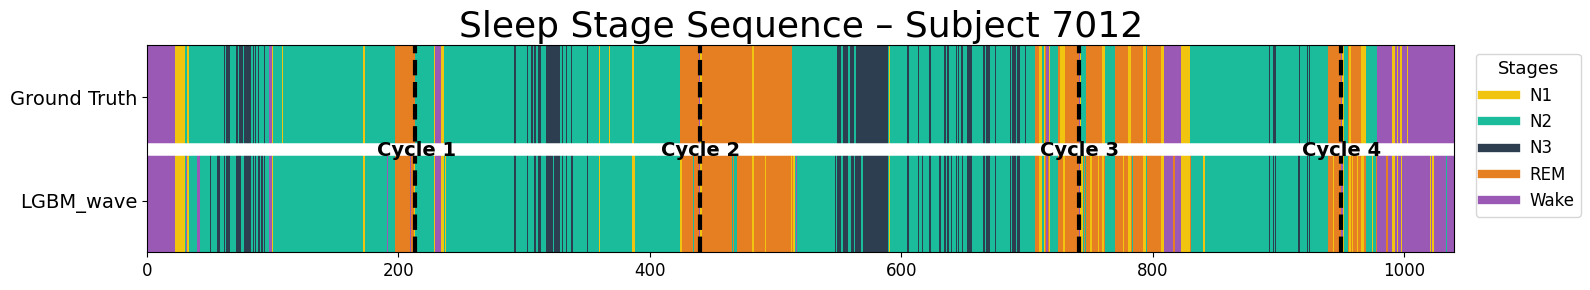

In [5]:
plot_subject_sequence(
    subject_id = 7012, 
    model=lgbm_pipeline,
    model_name='LGBM_wave',
    df=df_edf,
    label_encoder=le, 
    n_epochs=10000
)

## Plots Look Awesome... Maybe *Too* Awesome? 
I'm quite concerned about the model being **overfit**, so let's test that by performing some cross-validation. Specifically unique to this data, I'll adapt Leave-One-Out-CV (LOO-CV) for Leave-One-Subject-Out-CV (LOSO-CV). It'll involve holding a random subject_id out of the model training process. That way we can simulate testing our model's performance on completely new data!

In [24]:
def loso_full(df: pd.DataFrame, model_class, model_name, n_trials=30,
                          save_plot=False, target_subject=None, plot_dir='../sleep_plots/'):
    '''
    Performs leave-one-subject-out cross-validation

    Args:
        df (pd.DataFrame): Dataset including 'label' and 'subject_id'
        model_class: Classifier to train (e.g., LGBMClassifier)
        model_name (str): Name used for reporting
        n_trials (int): Number of Optuna trials for tuning
        save_plot (bool): Toggle to save plots 
        plot_dir (str): Directory to save plots

    Returns:
        results (dict): Dictionary mapping subject_id to evaluation result
    '''

    results = {}
    if target_subject is not None:
        subjects = [target_subject]
    else:
        subjects = df['subject_id'].unique()

    for left_out in subjects:
        print(f"\n🚪 Leaving out Subject {left_out}...\n")

        df_train = df[df['subject_id'] != left_out].copy()
        df_test = df[df['subject_id'] == left_out].copy()

        if df_test.empty:
            print(f"⚠️ No data found for subject {left_out}, skipping.")
            continue

        le = LabelEncoder()
        le.fit(df_train['label']) 

        y_train = le.fit_transform(df_train['label'])
        y_test = le.transform(df_test['label'])

        X_train = df_train.drop(columns=['label'])
        X_test = df_test.drop(columns=['label']) 

        trained_model, best_params = tune_and_train_full(
            model_class=model_class,
            model_name=f"{model_name}_{left_out}",
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test, 
            model_params={'class_weight': 'balanced'},
            sample_frac=0.9,
            scoring='f1_weighted',
            use_scaler=False,
            n_trials=n_trials,
            label_encoder=le)
        
        results[left_out] = {
            'model' : trained_model,
            'best_params' : best_params, 
            'label_encoder' : le,
        }

        # Optional-- plot or save:
        if save_plot: 
            save_path = os.path.join(plot_dir, f'{model_name}_{left_out}.png')
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
        else: 
            save_path = None

        plot_subject_sequence(
            subject_id = left_out,
            model = trained_model,
            model_name = f'{model_name}_{left_out}',
            df = df, 
            label_encoder= le, 
            n_epochs= len(df_test),
            save_path=save_path
        )

    return results

    


🚪 Leaving out Subject 7011...


📦 Training features: ['delta', 'theta', 'alpha', 'beta', 'cycle']
🔍 Sampled 41183 rows (99.0%)
Class distribution:
1    19129
3     8145
2     6216
4     4177
0     3516



🔍 Tuning: 100%|████████████████████████████████████████████████████| 30/30 [07:18<00:00, 14.60s/it]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 41183, number of used features: 5
[LightGBM] [Info] Start training from score -2.460702
[LightGBM] [Info] Start training from score -0.766820
[LightGBM] [Info] Start training from score -1.890899
[LightGBM] [Info] Start training from score -1.620621
[LightGBM] [Info] Start training from score -2.288432
[TRAINING] Starting model training...

→ Training LGBM_loso_7011 with params:
{
    "class_weight": "balanced",
    "n_estimators": 350,
    "max_depth": 49,
    "learning_rate": 0.05590244682522378,
    "num_leaves": 36
}
Scaling: OFF
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1026
[LightGBM]

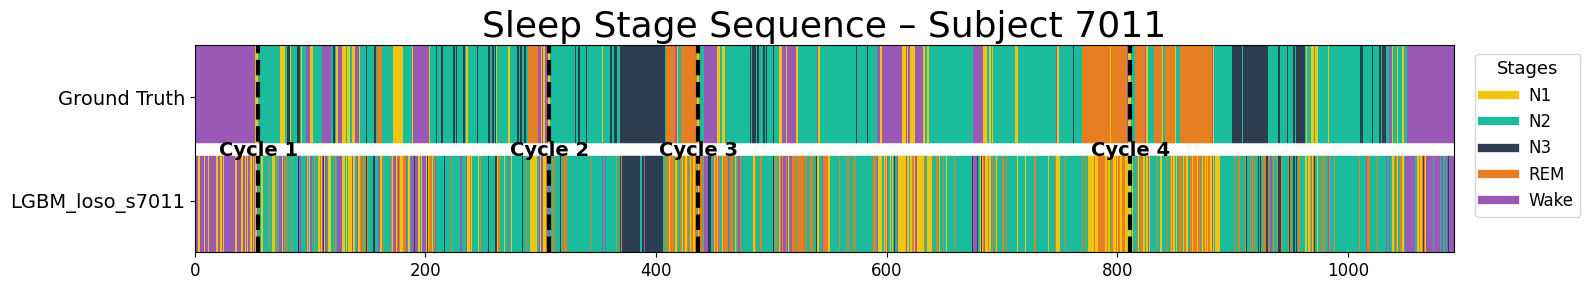

In [37]:
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from src.run_pipeline import tune_and_train_full
from src.models.loso import loso_full

loso_results = loso_full(
    df=df_edf, 
    model_class=LGBMClassifier,
    model_name='LGBM_loso',
    n_trials=30,
    save_plot=True,
    target_subject=7011,
    target_col='label') 


In [30]:
import joblib
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # y is label column
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=10)

loso_7021 = joblib.load('../models/LGBM_loso_7021.pkl')
loso_7011 = joblib.load('../models/LGBM_loso_7011.pkl') 
loso_7012 = joblib.load('../models/LGBM_loso_7012.pkl') 
loso_7162 = joblib.load('../models/LGBM_loso_7162.pkl') 

In [ ]:
from src.models.loso import plot_subject_sequence

plot_subject_sequence(7011, 
                      loso_7011, 
                      'LGBM_loso_7011', 
                      df_edf, 
                      le, 
                      n_epochs=1000000000000)

In [70]:
# df_edf['cycle'].value_counts(normalize=True)

# df_edf.groupby('subject_id')['cycle'].mean()
df_edf['cycle'].mean()

np.float64(2.2481085006207397)

## Intelligent Feature Tracking System
1. Define feature function (adds to df_edf)
2. Log the feature name + code
3. Apply to eeg_hypno.csv 
4. Run LOSO on 1 subject 
5. Save results (metrics + config) 
6. Repeat with new features!

In [28]:
FEATURE_REGISTRY = [] 

def register_feature(name, feature_func, notes=''): 
    '''
    Registers a new feature function with a name and notes

    Args: 
        name (str): Name of the feature
        feature_func (callable): Function to compute the feature
        notes (str): Optional notes about the feature
    '''
    FEATURE_REGISTRY.append({
        'name': name,
        'func': feature_func,
        'notes': notes
    })
    print(f"✅ Registered feature: {name}")

#### Adding Temporal Contexts

In [29]:
def feat_temporal_t1(df:pd.DataFrame): 
    return add_temporal_context(df, ['delta', 'theta', 'alpha', 'beta'], shifts=[-1,1])

register_feature(
    name='+- temporal bandpower',
    feature_func=feat_temporal_t1,
    notes='Adds t-1 and t+1 EEG band powers. Drops NaNs at edges'
)

✅ Registered feature: +- temporal bandpower


#### Run + Track Experiment Results

In [ ]:
RESULT_LOG = []

def run_feature_experiment_loso(
        df:pd.DataFrame,
        feature_entry, 
        target_subject,
        model_class, 
        model_name, 
        n_trials=30, 
        save_plot=True): 
    '''
    Applies a feature func, runs LOSO and logs results (RESULT LOG)

    Parameters: 
        base_df (pd.DataFrame):  df_edf (raw)
        feature_entry (dict): Feat registry ('name', 'func', 'notes', etc.)
        target_subject (int): Subject ID to leave out and test on
        model_class (sklearn): ex. RandomForestClassifier
        model_name (str): Name for model tracking
        n_trials (int): Number of trials for Optuna
        save_plot (bool): Whether or not to save plots

    Returns: 
        results (dict): Dictionary with feature metadata
    '''
    # Apply feature transformation: 
    df_feat = feature_entry['func'](df.copy()) 

    # Run LOSO
    results = loso_full(
        df=df_feat, 
        model_class=model_class,
        model_name=model_name,
        n_trials=n_trials,
        save_plot=save_plot,
        target_subject=target_subject)
    
    # Add metadata 
    results['feature_name'] = feature_entry['name'] 
    results['notes'] = feature_entry['notes']
    results['target_subject'] = target_subject
    results['model_used'] = model_name

    return results



In [ ]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from src.run_pipeline import tune_and_train_full

# set the feature to test: 
feature_to_test = FEATURE_REGISTRY[0] 

# Select model and subject:
model_class = LGBMClassifier
target_subject = 7242

# Descriptive model name: 
model_name = f'{model_class.__name__}_loso_{feature_to_test['name'].replace(" ", "_")}'

# Run the experiment: 
result = run_feature_experiment_loso(
    base_df=df_edf, 
    feature_entry=feature_to_test, 
    target_subject=target_subject,
    model_class=model_class, 
    model_name=model_name,
    n_trials=30, 
    save_plot=True
)

## Binary Classification
It might be advantageous to turn this multiclass problem into a binary classification problem (REM and NREM) 

In [ ]:
# Something something [N1, N2, N3, Wake] in NREM
# Should strengthen classification 
# If we need to include N1 in the REM category for biowake purposes... 
# That can be arranged, we'll just rename the cats to something suitable



In [ ]:
# Removed subject_id from model training
# Lead to an unfortunate but important drop in both binary and multi metrics 
# Seems there was some overfitting going on after all... 
# Models were "cheating" by learning patterns directly from the subject 
# (instead of just getting good at learning from bands)

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should now be True!
print(torch.cuda.get_device_name())  # Should say RTX 4070

2.7.0+cu118
True
NVIDIA GeForce RTX 4070 Laptop GPU


In [1]:
df_edf

NameError: name 'df_edf' is not defined

In [ ]:
from src.datasets.sequence_dataset import LSTMDataset

dataset = LSTMDataset(df_edf, feature_cols=['delta', 'theta', 'alpha', 'beta', 'cycle', 'norm_time', 'label'], window_size=10, seq2seq=True)

x, y = dataset[0]
print(x.shape)  
print(y.shape) 

In [16]:
df_edf[df_edf['label'] == 'REM'][['delta', 'theta', 'alpha', 'beta']].describe()


,delta,theta,alpha,beta
count,8.349000e+03,8.349000e+03,8.349000e+03,8.349000e+03
mean,3.221615e-11,5.315007e-12,1.649456e-12,5.852052e-13
std,3.578095e-11,3.617487e-12,1.324684e-12,7.174190e-13
min,2.600732e-12,7.168107e-13,2.715201e-13,1.107537e-13
25%,1.338291e-11,2.983952e-12,8.496138e-13,2.646855e-13
50%,2.214247e-11,4.415837e-12,1.214784e-12,3.750883e-13
75%,3.763348e-11,6.430798e-12,1.948605e-12,6.022325e-13
max,7.712539e-10,4.077287e-11,2.035418e-11,2.887856e-11


In [19]:
import os 
import sys 

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(PROJECT_ROOT)

from src.tune import optuna_lstm_tuner


from src.utils.loaders import load_eeg_data

# Load your EEG dataset and feature list
df = load_eeg_data("eeg_hypno.csv")  # or whatever your default is
features = ['delta', 'theta', 'alpha', 'beta', 'cycle', 'norm_time']

# Create a static config just like the CLI does
static_config = {
    "df": df,
    "feature_cols": features,
    "label_col": "binary_label",
    "is_binary": True,
    "verbose": False,
    "auto_thresh": True,
    "plot_thresholds": False,
}

In [20]:



from src.tune import optuna_lstm_tuner

best_params, study = optuna_lstm_tuner(
    n_trials = 5, 
    random_state =10, 
    static_config=static_config,
    subject_list=[7242]
)

[INFO] Using device: cuda


✅ LSTM training complete.


[METRICS] | Weighted F1: 0.0591 | Accuracy: 0.1872

[INFO] Using device: cuda


✅ LSTM training complete.


[METRICS] | Weighted F1: 0.8282 | Accuracy: 0.8421

[INFO] Using device: cuda


✅ LSTM training complete.


[METRICS] | Weighted F1: 0.0631 | Accuracy: 0.1941

[INFO] Using device: cuda
✅ LSTM training complete.




[METRICS] | Weighted F1: 0.7995 | Accuracy: 0.8006

[INFO] Using device: cuda


🔍 Tuning: 100%|██████████████████████████████████████████████████████| 5/5 [01:07<00:00, 13.57s/it]

✅ LSTM training complete.


[METRICS] | Weighted F1: 0.7965 | Accuracy: 0.7924

✅ Exported subject scores to c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\logs\optuna_lstm_05-20.csv
✅ Exported subject scores to c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\logs\optuna_lstm_05-20.csv
✅ Exported subject scores to c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\logs\optuna_lstm_05-20.csv
✅ Exported subject scores to c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\logs\optuna_lstm_05-20.csv
✅ Exported subject scores to c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\logs\optuna_lstm_05-20.csv


In [21]:
from optuna.visualization import plot_parallel_coordinate, plot_contour
import plotly.io as pio

# Optional: force Plotly to use Kaleido
pio.kaleido.scope.default_format = "png"

fig = plot_parallel_coordinate(study)
fig.write_image("debug_parallel.png")

fig2 = plot_contour(study, params=["learning_rate", "dropout"])  # or any other pair
fig2.write_image("debug_contour.png")


In [23]:
from optuna.visualization import plot_parallel_coordinate

fig = plot_parallel_coordinate(study) 
fig.show()

In [25]:
from optuna.visualization import plot_contour

fig = plot_contour(study)
fig.show() 

In [26]:
plot_contour(study, params=["learning_rate", "dropout"])


In [ ]:
# Next, line plot tracking f1s across the trials
# Figure out if there's a patter (ex. f1 improvement)

# TO DO: 
# Test generalizeability on more (and eventually all) subjects
# Lead Scoring vs LTV -- and why they're two parts of a sales funnel
# Expanding Phase 4 to have 5 subphases 
# -- will cover all steps in the Keyspire Funnel
# -- more progress needed on Pitch Deck today
# -- but that's only viable once the Roadmap is in a better spot


# ---- Sleep_Wave ---- 
# lr is consistently the most important param, correlating with great f1 scores 
# It's correlation is so extremely negative, reminder to tune lr down in optuna
# Just to see if it has an effect
# Success... sort of!

# Spoke with Charlie, he's still interested in real-time sleep_wave
# Think about how the script would have to adapt for real-time

## Real-Time Classification Simulation

In [ ]:
# Idea: StreamSim class... that feeds one 30s epoch at a time 

In [4]:

import sys 
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(PROJECT_ROOT)

import pandas as pd
import matplotlib.pyplot as plt
from src.paths import DATA_DIR

print("DATA_DIR = ", DATA_DIR.resolve())
print("Matching PSGs:")
for f in DATA_DIR.glob("ST7012J*-PSG.edf"):
    print(" -", f.name)


DATA_DIR =  C:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data
Matching PSGs:
